## Washington State COVID-19 Predictor Model

The purpose of this project is to use a machine learning model to predict the number of positive COVID 19 cases in the state of Washington and my county of residence King County for one week from Monday April 20, 2020 through Sunday April 26, 2020. This is done purely for education purposes. We will also explore predicting fatalities in both the state and county as well, although they are not the primary focus here. The data we will be using is obtained from two different sources. We will use the __[Washington State Department of Health](https://www.doh.wa.gov/Emergencies/Coronavirus)__ as well as __[Washington State Hospital Association](https://www.wsha.org/for-patients/coronavirus/coronavirus-tracker/)__ for our data. The two sites were used to ensure the accuracy of our data. The data we are interested in was put into a simple excel spreadsheet. We will be using the data available from these sources as of April 19, 2020 to predict the next week. Below we will explore the data.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
from datetime import datetime
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

wa_state_covid = pd.read_excel(r"C:\Users\kenp8\Documents\WA COVID-19 info.xlsx")

In [27]:
wa_state_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 6 columns):
date                  99 non-null datetime64[ns]
Unnamed: 1            0 non-null float64
wa_total_cases        99 non-null int64
wa_fatalities         99 non-null int64
king_co_total         99 non-null int64
king_co_fatalities    99 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 4.8 KB


In [28]:
wa_state_covid.head()

,date,Unnamed: 1,wa_total_cases,wa_fatalities,king_co_total,king_co_fatalities
0,2020-01-20,NaN,1,0,1,0
1,2020-01-21,NaN,1,0,1,0
2,2020-01-22,NaN,1,0,1,0
3,2020-01-23,NaN,1,0,1,0
4,2020-01-24,NaN,1,0,1,0


## Data Cleaning

We have pretty clean data here. No missing values and all columns are of the type we need for our model. We will clean it up a bit by removing the empty column.

We also need to be conscious that the Washington State or King County Department of health occasionally will correct the number of positive cases from previous days. For example, on 3/18/20 the King County Department of health reported 7 fewer positive cases than the previous day. As this is not true to what happens and creates false noise in our data we will compare the difference in positive COVID-19 cases or fatalities in all our rows to the previous day. If that value is negative, we will set the previous day's value from that column to the current day value.

In [29]:
#dropping the empty column
wa_state_covid = wa_state_covid.drop("Unnamed: 1", axis=1)

In [30]:
#ensuring case numbers don't decrease from one day to the next
columns = wa_state_covid.columns
num_columns = columns.drop("date")
num_columns

for i in range(1, len(wa_state_covid)):
    for column in num_columns:
         if wa_state_covid.loc[i, column] < wa_state_covid.loc[(i-1), column]:
                wa_state_covid.loc[(i-1), column] = wa_state_covid.loc[i, column]

#check work
wa_state_covid[56:60]

,date,wa_total_cases,wa_fatalities,king_co_total,king_co_fatalities
56,2020-03-16,904,48,488,43
57,2020-03-17,1012,52,562,43
58,2020-03-18,1187,66,562,56
59,2020-03-19,1376,74,693,60


## Data Exploration

We will start by taking a look at some of our data. We will start with all the numeric columns and do a scatter plot with the date to look at the shape of data.

In [31]:
#establishing DataFrame so we are only looking at data available 4/19/20 and before
df = wa_state_covid[:91].copy()
df.tail()

,date,wa_total_cases,wa_fatalities,king_co_total,king_co_fatalities
86,2020-04-15,11152,583,4796,320
87,2020-04-16,11445,603,4865,330
88,2020-04-17,11790,624,5024,339
89,2020-04-18,11790,634,5135,346
90,2020-04-19,12085,652,5259,358


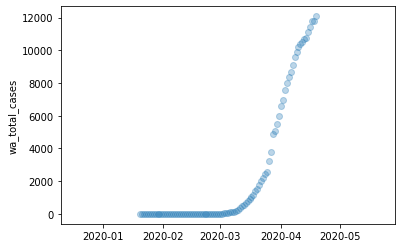

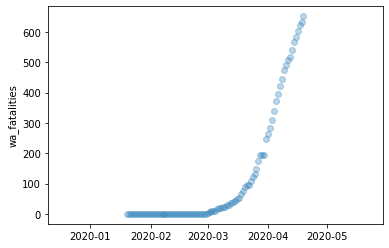

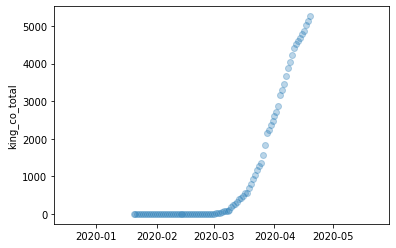

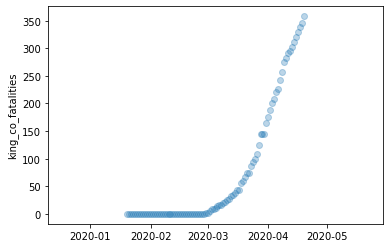

In [32]:
#scatterplots of all the columns
for i in num_columns:
    plt.scatter(df["date"], df[i], alpha=0.3);
    plt.ylabel(i)
    plt.show()

In the above scatter plots, we can see that the increase in cases is not a linear function, just as we would expect with the spread of a virus. The slope of the data near the later portion of data looks fairly linear, indicating that the growth is not completely exponential either. A good indication that the social distancing and "stay home, stay healthy" orders are having an impact on the number of positive cases and deaths. We see that we do not have a whole lot of data with 91 rows and 5 columns. We will continue our data exploration using what we have just observed. We will investigate the exponential nature of the __[growth](https://en.wikipedia.org/wiki/Exponential_growth)__. We will establish an exponential growth factor for the total amount of positive cases in Washington state and observe what that looks like.

In [33]:
#need to get time since beginning of cases into integer form
#finding the day of year
df["day_of_year"] = df.date.dt.dayofyear

#establishing how many days since beginning of outbreak
df["days_since_first_case"] = (df["day_of_year"] - df["day_of_year"][0])

#using exponential growth rate formula
df["wa_case_ln_factor"] = np.log(df["wa_total_cases"] / df["wa_total_cases"][0])/ ( 
df["days_since_first_case"])

#fill in NaN when dividing by zero 
df["wa_case_ln_factor"].fillna(0, inplace=True)

#check work
df.head()

,date,wa_total_cases,wa_fatalities,king_co_total,king_co_fatalities,day_of_year,days_since_first_case,wa_case_ln_factor
0,2020-01-20,1,0,1,0,20,0,0.0
1,2020-01-21,1,0,1,0,21,1,0.0
2,2020-01-22,1,0,1,0,22,2,0.0
3,2020-01-23,1,0,1,0,23,3,0.0
4,2020-01-24,1,0,1,0,24,4,0.0


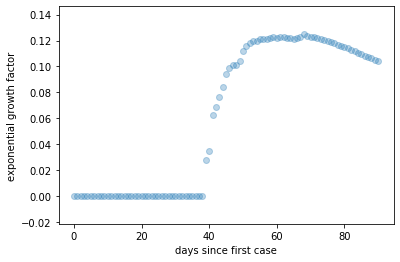

In [34]:
#looking at exponential growth vs. time since beginning of outbreak

plt.scatter(df["days_since_first_case"], df['wa_case_ln_factor'], alpha=0.3);
plt.ylabel("exponential growth factor")
plt.xlabel("days since first case")
plt.show()

We can clearly see that the growth of the total number of positive COVID-19 cases in Washington state has become less and less exponential as time has progressed. The other three columns in our data would follow the same trend given their very similarly shaped scatter plots.

### Linear regression

Below we will fit a line to the above data for the `wa_total_cases` column. We know this will likely not produce a good result, but it gives us a starting point.

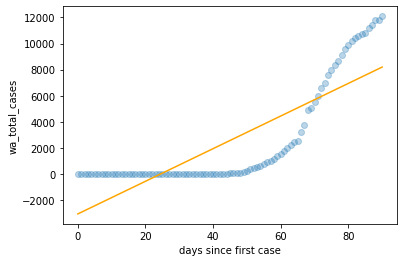

In [35]:
model = LinearRegression(fit_intercept=True)

X = df['days_since_first_case'][:, np.newaxis]
y = df['wa_total_cases']

model.fit(X, y)

x_min = df['days_since_first_case'].min()
x_max = df['days_since_first_case'].max()
x_plot = np.linspace(x_min, x_max)
y_plot = model.predict(x_plot[:, np.newaxis])

plt.scatter(df['days_since_first_case'], df['wa_total_cases'], alpha=0.3)
plt.ylabel('wa_total_cases')
plt.xlabel('days since first case')
plt.plot(x_plot, y_plot, c='orange');

In [36]:
from sklearn.metrics import r2_score
model = LinearRegression(fit_intercept=True)

model.fit(df['days_since_first_case'][:, np.newaxis], df['wa_total_cases'])

predictions = model.predict(df['days_since_first_case'][:, np.newaxis])
r2_score(df['wa_total_cases'], predictions)

0.6822117662701237

The best fit line is quite a bit lower than our most recent data and we can easily see we would predict considerably lower than the actuals for the next week. We can also observe that our $R^2$ score is not particularly great just as we would expect.

### Polynomial Regression

Next we will try to fit a polynomial of varying degrees (2 through 5) to our data and plot it to observe what that looks like and calculate $R^2$ scores for each.

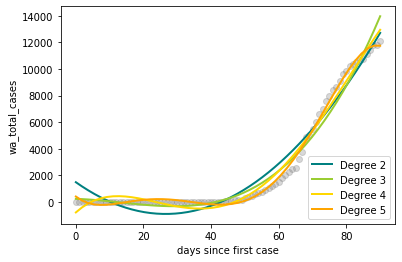

Degree 2 r-squared score: 0.9590968790221951
Degree 3 r-squared score: 0.9753521996904434
Degree 4 r-squared score: 0.9845017438807742
Degree 5 r-squared score: 0.9960089283229954


In [37]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline 
colors = ['teal', 'yellowgreen', 'gold', 'orange']

x_min = df['days_since_first_case'].min()
x_max = df['days_since_first_case'].max()
x_plot = np.linspace(x_min, x_max)

plt.scatter(df['days_since_first_case'], df['wa_total_cases'], alpha=0.3, c='gray')

for count, degree in enumerate([2, 3, 4, 5]):
    model = make_pipeline(PolynomialFeatures(degree),
                         LinearRegression())
    X = df['days_since_first_case'][:, np.newaxis]
    y = df['wa_total_cases']
    model.fit(X, y)
    y_plot = model.predict(x_plot[:, np.newaxis])
    plt.plot(x_plot, y_plot, color=colors[count], 
             linewidth=2, label="Degree %d" % degree)

plt.legend(loc='lower right')
plt.ylabel('wa_total_cases')
plt.xlabel('days since first case')
plt.show();

for count, degree in enumerate([2,3,4,5]):
    model = make_pipeline(PolynomialFeatures(degree),
                         LinearRegression())
    X = df['days_since_first_case'][:, np.newaxis]
    y = df['wa_total_cases']
    model.fit(X, y)
    predictions = model.predict(X)
    print("Degree %d" % degree, "r-squared score:", 
          r2_score(df['wa_total_cases'], predictions))

In the scatter plot above it is pretty easy to see we improved greatly on a simple linear regression. Our 5th degree polynomial is overfitting and it is curling near our most recent data and would likely have a negative slope in the coming week, which is undesirable. The second, third and fourth degree polynomials are all diverging above our data at the most recent date. Although the $R^2$ scores are vastly improved from our regular linear regression none of the four look like good candidates for predicting cases in the coming week.

During our EDA we noticed that the data closer to the most recent dates appeared to be a bit more linear in nature. We also know that the number of cases and fatalities will never decrease. In order to take advantage of this, we will use the data that begins the day before the cases in Washington state started to increase. This should give us a better model by capturing the amount of the virus spread since it began increasing, ignoring when there was only 1 case in the state and King county. We will also create a new column `days_since_case_increase` to effectively start the clock over on our dates.

In [38]:
#creating a DataFrame that only includes from the day (2/27/2020) before cases started to increase
df_increase = df[38:91].copy()
df_increase['days_since_case_increase'] = df_increase['days_since_first_case'] - df_increase['days_since_first_case'][38]
df_increase.head()

,date,wa_total_cases,wa_fatalities,king_co_total,king_co_fatalities,day_of_year,days_since_first_case,wa_case_ln_factor,days_since_case_increase
38,2020-02-27,1,0,1,0,58,38,0.000000,0
39,2020-02-28,3,0,1,0,59,39,0.028170,1
40,2020-02-29,4,1,2,1,60,40,0.034657,2
41,2020-03-01,13,2,10,2,61,41,0.062560,3
42,2020-03-02,18,6,14,5,62,42,0.068818,4


Now that we have our data, we will examine the scatter plots once again.

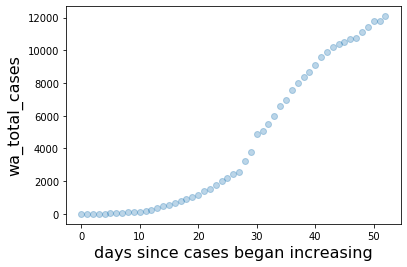

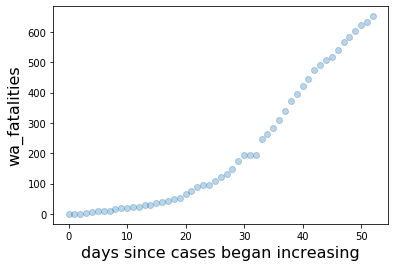

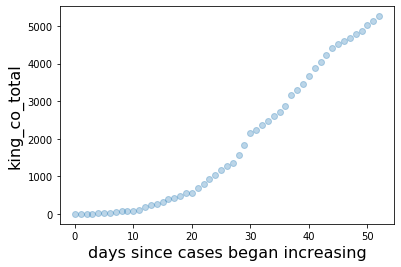

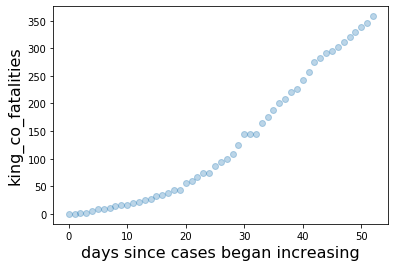

In [39]:
for column in num_columns:
    plt.scatter(df_increase["days_since_case_increase"], df_increase[column], alpha=0.3)
    plt.ylabel(column, fontsize=16)
    plt.xlabel('days since cases began increasing', fontsize=16)
    plt.show()

These scatter plots look a bit more promising. There is not the long duration of time spent without cases increasing. Once again, we will work on fitting polynomials of varying degrees. This time we will do it for all our columns and calculate $R^2$ scores.

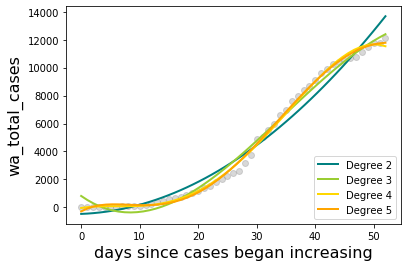

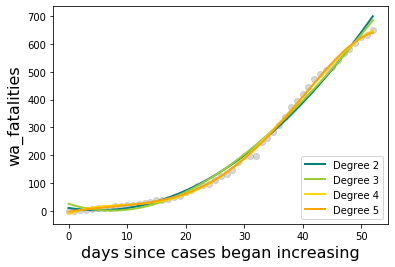

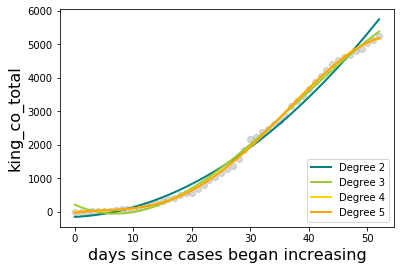

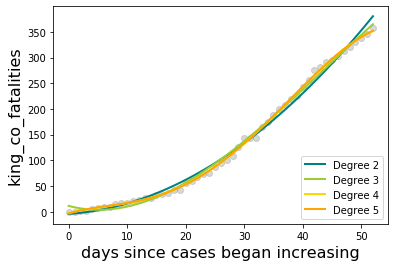

wa_total_cases:
Degree 2 r-squared score: 0.9747104679105049
Degree 3 r-squared score: 0.990406124227322
Degree 4 r-squared score: 0.9967732145643423
Degree 5 r-squared score: 0.9972890340703143


wa_fatalities:
Degree 2 r-squared score: 0.9930942681361458
Degree 3 r-squared score: 0.9939455166944825
Degree 4 r-squared score: 0.9986038806821999
Degree 5 r-squared score: 0.998816983943642


king_co_total:
Degree 2 r-squared score: 0.9890028979123744
Degree 3 r-squared score: 0.9964732515127264
Degree 4 r-squared score: 0.9988787063388146
Degree 5 r-squared score: 0.9989202246111165


king_co_fatalities:
Degree 2 r-squared score: 0.9936580810332142
Degree 3 r-squared score: 0.9968377435988006
Degree 4 r-squared score: 0.9990641645410733
Degree 5 r-squared score: 0.999079626917436




In [40]:
colors = ['teal', 'yellowgreen', 'gold', 'orange']

x_min = df_increase['days_since_case_increase'].min()
x_max = df_increase['days_since_case_increase'].max()
x_plot = np.linspace(x_min, x_max)

for column in num_columns:

    plt.scatter(df_increase['days_since_case_increase'], df_increase[column], alpha=0.3, c='gray')

    for count, degree in enumerate([2, 3, 4, 5]):
        model = make_pipeline(PolynomialFeatures(degree),
                         LinearRegression())
        X = df_increase['days_since_case_increase'][:, np.newaxis]
        y = df_increase[column]
        model.fit(X, y)
        y_plot = model.predict(x_plot[:, np.newaxis])
        plt.plot(x_plot, y_plot, color=colors[count], 
             linewidth=2, label="Degree %d" % degree)
        plt.ylabel(column, fontsize=16)
        plt.xlabel('days since cases began increasing', fontsize=16)

    plt.legend(loc='lower right')
    
    plt.show()
    
for column in num_columns:
    print("%s:" % column)
    for count, degree in enumerate([2,3,4,5]):
        model = make_pipeline(PolynomialFeatures(degree),
                         LinearRegression())
        X = df_increase['days_since_case_increase'][:, np.newaxis]
        y = df_increase[column]
        model.fit(X, y)
        predictions = model.predict(X)
        print("Degree %d" % degree, "r-squared score:", 
          r2_score(df_increase[column], predictions))
    print("\n") 

All The $R^2$ scores above give particularly good results fitting to our data. The second degree polynomial appears to be diverging to the upside from our data at the most recent dates. This would lead to overestimating cases and fatalities in the next week, with error likely worsening as the week went on. The fourth and fifth degree polynomials appear to be overfitting. Again, their slope is decreasing near the most recent data, which would likely lead to a large decrease in values over time. The third degree polynomial looks like a decent model for all but the `wa_fatalities` column. Again, we see a divergence to the upside by the `wa_fatalities` model near our most recent dates. However, our primary focus in this project is the forecasting of overall COVID-19 cases for the next week. We will use the three-degree polynomial for all four of our predictions.

## Models

Below, we will use our three-degree polynomials to predict values for all our case and fatality columns for the next week. We will also show the coefficients and intercepts for further understanding. Additionally, we will examine them visually to get an idea of what the predictions look like compared to our existing data. We will carry our prediction lines out for two weeks to help further understand the nature of the polynomials we are using for our predictions.

Model slopes:     [ 0.00000000e+00 -2.94942438e+02  2.00293734e+01 -1.93787745e-01]
Model intercept: 817.5745187756493
Predictions for the week of 4/21/20 to 4/26/20 for wa_total_cases are: [12597, 12781, 12943, 13080, 13193, 13279, 13338] 



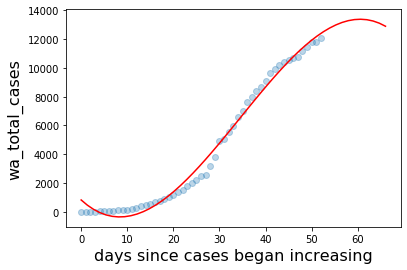

Model slopes:     [ 0.00000000e+00 -6.81148137e+00  4.91144261e-01 -2.22816399e-03]
Model intercept: 24.61053935579551
Predictions for the week of 4/21/20 to 4/26/20 for wa_fatalities are: [711, 738, 764, 792, 819, 847, 874] 



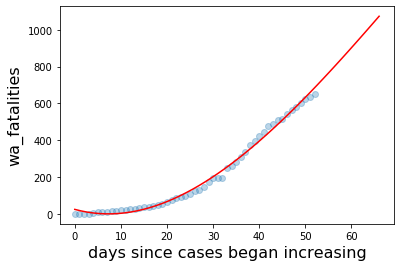

Model slopes:     [ 0.00000000e+00 -7.99455370e+01  6.32460799e+00 -5.53108420e-02]
Model intercept: 211.8486754340213
Predictions for the week of 4/21/20 to 4/26/20 for king_co_total are: [5506, 5627, 5744, 5855, 5960, 6059, 6151] 



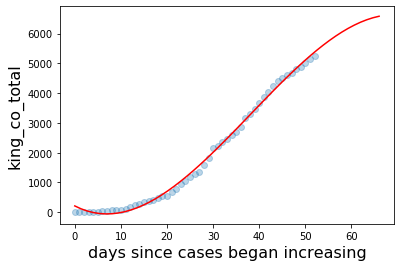

Model slopes:     [ 0.00000000e+00 -2.99754055e+00  3.10251581e-01 -2.34320495e-03]
Model intercept: 11.276443682099142
Predictions for the week of 4/21/20 to 4/26/20 for king_co_fatalities are: [375, 385, 395, 404, 414, 423, 433] 



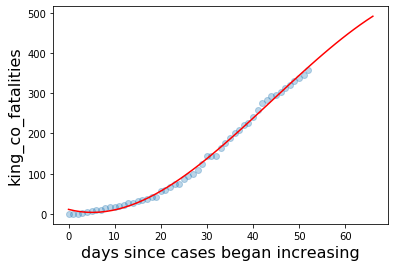

In [41]:
#fitting data with 3 degree polynomial
for column in num_columns:
    poly = PolynomialFeatures(degree=3)

    X = df_increase['days_since_case_increase'][:, np.newaxis]
    y = df_increase[column]

    x_min = df_increase['days_since_case_increase'].min()
#showing for two weeks to check for negative slope and any odd shapes
    x_max = df_increase['days_since_case_increase'].max() + 14
    x_plot = np.linspace(x_min, x_max)
    x_fit = poly.fit_transform(x_plot[:, np.newaxis])
    X_ = poly.fit_transform(X)


    poly_model = LinearRegression(fit_intercept=True)
    poly_model.fit(X_, y)

    x_fit[:, np.newaxis]
    y_fit = poly_model.predict(x_fit)

#visually showing existing data and prediction line
    plt.scatter(df_increase['days_since_case_increase'], df_increase[column], alpha=0.3)
    plt.plot(x_fit[:, 1], y_fit, c='red')
    plt.ylabel(column, fontsize=16)
    plt.xlabel('days since cases began increasing', fontsize=16)

#showing coefficients and intercept
    print("Model slopes:    ", poly_model.coef_)
    print("Model intercept:", poly_model.intercept_)
    
#calculating and showing predictions for the week    
    week_predictions = []
    for i in range((df_increase['days_since_case_increase'].max() + 1), (
        df_increase['days_since_case_increase'].max() +8)):
        daily_prediction = poly_model.intercept_ + i * poly_model.coef_[1] + (i**2)*poly_model.coef_[2] + (
            i**3)*poly_model.coef_[3]
        week_predictions.append(int(daily_prediction))
    print("Predictions for the week of 4/21/20 to 4/26/20 for %s" % column, "are: %s" % week_predictions,"\n")
    
    plt.show()

### Expectations of Model Performance

After examining the above visualizations, we will make some predictions for our model performance over the next week. The first thing that stands out is that the `wa_fatalities` appears to be diverging from the data a decent amount. We expect this model to predict higher than actual for the week, with a likelihood it will perform worse as the week goes on. The `wa_total_cases` model looks to be flattening out near our most recent data and heading for a negative slope inside of two weeks. We expect this model to predict slightly high at the beginning of the week and accurate to slightly low toward the end of the week. The `king_co_total` model looks to be slightly high toward the beginning of the week, possibly getting a little more accurate as the week goes on given its flattening slope. The `king_co_fatalities` model looks pretty linear for the next week. We expect it to be fairly accurate with equal chance of predicting high or low on any given day.

## Evaluating Model Performance

Next, we will use what we did above to create a `poly_fit` function that will help us get our predictions stored in a new DataFrame `true_value_df`. In addition, we will create new columns to help evaluate performance for each of the models. We will include the absolute difference in COVID-19 cases and fatalities as well as the percentage error for each model. This was done in lieu of $R^2$ given that there are very few data points we are predicting.

In [42]:
#function to get predictions for week for each of our 4 models
def poly_fit(column):
    poly = PolynomialFeatures(degree=3)

    X = df_increase['days_since_case_increase'][:, np.newaxis]
    y = df_increase[column]

    X_ = poly.fit_transform(X)

    poly_model = LinearRegression(fit_intercept=True)
    poly_model.fit(X_, y)

    week_predictions = []
    for i in range((df_increase['days_since_case_increase'].max() + 1), (
        df_increase['days_since_case_increase'].max() +8)):
        daily_prediction = poly_model.intercept_ + i * poly_model.coef_[1] + (i**2)*poly_model.coef_[2] + (
            i**3)*poly_model.coef_[3]
        week_predictions.append(int(daily_prediction))
    
    return week_predictions

In [43]:
true_value_df = pd.DataFrame(columns = num_columns, data = wa_state_covid[91:98])
true_value_df.insert(0, 'date', wa_state_covid['date'][91:98])

#adding estimate data and measures
true_value_df.insert(2, 'wa_case_est', poly_fit('wa_total_cases'))
true_value_df.insert(3, 'wa_case_diff', (true_value_df.wa_total_cases - true_value_df.wa_case_est))
true_value_df.insert(4, 'wa_case_pct_miss', round((true_value_df.wa_case_diff / true_value_df.wa_total_cases) * 100, 2))

true_value_df.insert(6, 'wa_fatl_est', poly_fit('wa_fatalities'))
true_value_df.insert(7, 'wa_fatl_diff', (true_value_df.wa_fatalities - true_value_df.wa_fatl_est))
true_value_df.insert(8, 'wa_fatl_pct_miss', round((true_value_df.wa_fatl_diff / true_value_df.wa_fatalities) * 100, 2))

true_value_df.insert(10, 'kingco_case_est', poly_fit('king_co_total'))
true_value_df.insert(11, 'kingco_case_diff', (true_value_df.king_co_total - true_value_df.kingco_case_est))
true_value_df.insert(12, 'kingco_case_pct_miss', round((
    true_value_df.kingco_case_diff / true_value_df.king_co_total) * 100, 2))

true_value_df.insert(14, 'kingco_fatl_est', poly_fit('king_co_fatalities'))
true_value_df.insert(15, 'kingco_fatl_diff', (true_value_df.king_co_fatalities - true_value_df.kingco_fatl_est))
true_value_df.insert(16, 'kingco_fatl_pct_miss', round((
    true_value_df.kingco_fatl_diff / true_value_df.king_co_fatalities) * 100, 2))

true_value_df

,date,wa_total_cases,wa_case_est,wa_case_diff,wa_case_pct_miss,wa_fatalities,wa_fatl_est,wa_fatl_diff,wa_fatl_pct_miss,king_co_total,kingco_case_est,kingco_case_diff,kingco_case_pct_miss,king_co_fatalities,kingco_fatl_est,kingco_fatl_diff,kingco_fatl_pct_miss
91,2020-04-20,12282,12597,-315,-2.56,682,711,-29,-4.25,5360,5506,-146,-2.72,373,375,-2,-0.54
92,2020-04-21,12494,12781,-287,-2.30,692,738,-46,-6.65,5427,5627,-200,-3.69,379,385,-6,-1.58
93,2020-04-22,12753,12943,-190,-1.49,711,764,-53,-7.45,5532,5744,-212,-3.83,385,395,-10,-2.60
94,2020-04-23,12977,13080,-103,-0.79,723,792,-69,-9.54,5637,5855,-218,-3.87,393,404,-11,-2.80
95,2020-04-24,13319,13193,126,0.95,738,819,-81,-10.98,5739,5960,-221,-3.85,400,414,-14,-3.50
96,2020-04-25,13521,13279,242,1.79,749,847,-98,-13.08,5863,6059,-196,-3.34,408,423,-15,-3.68
97,2020-04-26,13686,13338,348,2.54,765,874,-109,-14.25,5945,6151,-206,-3.47,416,433,-17,-4.09


Now that we have our `true_value_df`, we will visualize below what happened with the actual values for the week compared to our model. We have also included the preexisting data we used to determine our polynomials for reference and further understanding.

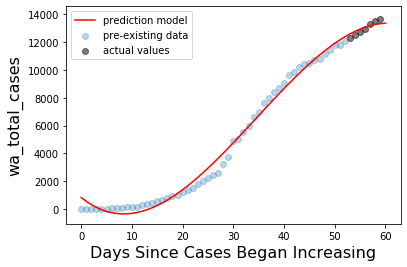

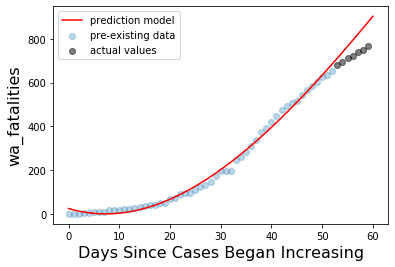

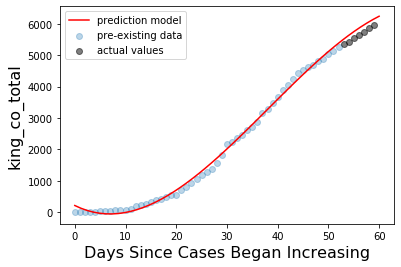

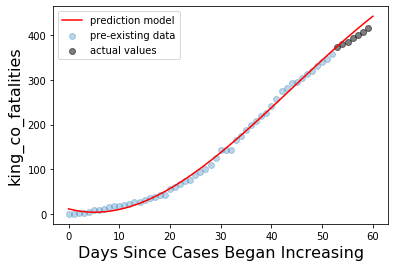

In [44]:
for column in num_columns:
    poly = PolynomialFeatures(degree=3)

    X = df_increase['days_since_case_increase'][:, np.newaxis]
    y = df_increase[column]

    x_min = df_increase['days_since_case_increase'].min()
    x_max = df_increase['days_since_case_increase'].max() + 8
    x_plot = np.linspace(x_min, x_max)
    x_fit = poly.fit_transform(x_plot[:, np.newaxis])
    X_ = poly.fit_transform(X)


    poly_model = LinearRegression(fit_intercept=True)
    poly_model.fit(X_, y)

    x_fit[:, np.newaxis]
    y_fit = poly_model.predict(x_fit)

#visually showing pre existing data and actual data from week and prediction line
    plt.scatter(df_increase['days_since_case_increase'], df_increase[column], alpha=0.3)
    plt.scatter((true_value_df.index - 38), true_value_df[column], alpha=0.5, color='black')
    plt.plot(x_fit[:, 1], y_fit, c='red')
    plt.ylabel(column, fontsize=16)
    plt.xlabel('Days Since Cases Began Increasing', fontsize=16)
    plt.legend(labels=['prediction model', 'pre-existing data', 'actual values'])
    
    plt.show()

We can see above that our `wa_total_cases` model fit right through the data for the week but would underestimate if it were modeling dates further out. The `king_co_total` model was consistently high for the week but seemed to follow the distribution shape for the week fairly well. The `wa_fatalities` model did not do well and got worse as the week went on. The model of `king_co_fatalities` looked like it did slightly better but also diverged from the actual near the end of the week. Below, we will look visually into raw data differences for each model as well as percentage error for each day.

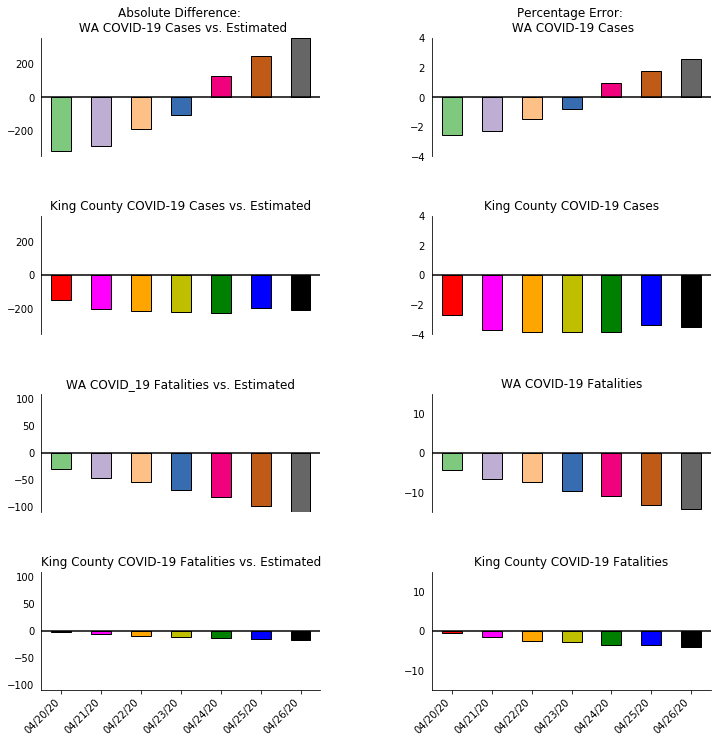

In [45]:
#plots of absolute difference and percentage miss
#put dates on bottom row

x_labels = []
for date in true_value_df['date']:
    x_labels.append(date.strftime(format = "%m/%d/%y"))
x_labels

colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, true_value_df.shape[0])]
color_2 = ['red', 'magenta', 'orange', 'y', 'green', 'blue', 'black']

fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (12,12))
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.flatten()
fig.subplots_adjust(wspace = .4, hspace = .5)

#top left Washington total postive COVID-19 cases
true_value_df['wa_case_diff'].plot.bar(ax = ax1, 
                                       color=colors,
                                       edgecolor='black',
                                       title = "Absolute Difference: \n WA COVID-19 Cases vs. Estimated")
ax1.set_ylim(-350, 350)
ax1.tick_params(axis='both', which ='both',  top=False, bottom=False, right=False, left=False, labelbottom=False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.axhline(0, color='black')


#top right percentage miss WA COVID-19 cases
true_value_df['wa_case_pct_miss'].plot.bar(ax = ax2,
                                           color=colors,
                                           edgecolor='black',
                                         title= "Percentage Error: \n WA COVID-19 Cases")
ax2.set_ylim(-4, 4)
ax2.tick_params(top=False, bottom=False, right=False, left=False, labelbottom=False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.axhline(0, color = 'black')

#Second down left King County total postive COVID-19 cases
true_value_df['kingco_case_diff'].plot.bar(ax = ax3,
                                           color=color_2,
                                           edgecolor='black',
                                       title = "King County COVID-19 Cases vs. Estimated")
ax3.set_ylim(-350, 350)
ax3.tick_params(axis='both', which ='both',  top=False, bottom=False, right=False, left=False, labelbottom=False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.axhline(0, color='black')

#Second down right percentage miss King County COVID-19 cases
true_value_df['kingco_case_pct_miss'].plot.bar(ax = ax4,
                                               color=color_2,
                                               edgecolor='black',
                                         title= "King County COVID-19 Cases")
ax4.set_ylim(-4,4)
ax4.tick_params(top=False, bottom=False, right=False, left=False, labelbottom=False)
ax4.spines['top'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.axhline(0, color = 'black')

#Third down on left WA Fatalities est. vs. actual
true_value_df['wa_fatl_diff'].plot.bar(ax = ax5, 
                                       color=colors,
                                       edgecolor='black',
                                       title = "WA COVID_19 Fatalities vs. Estimated")
ax5.set_ylim(-110, 110)
ax5.tick_params(axis='both', which ='both',  top=False, bottom=False, right=False, left=False, labelbottom=False)
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['bottom'].set_visible(False)
ax5.axhline(0, color='black')

#Third down right Washington Fatalities est. vs. actual
true_value_df['wa_fatl_pct_miss'].plot.bar(ax = ax6,
                                           color=colors,
                                           edgecolor='black',
                                         title= "WA COVID-19 Fatalities")
ax6.set_ylim(-15, 15)
ax6.tick_params(top=False, bottom=False, right=False, left=False, labelbottom=False)
ax6.spines['top'].set_visible(False)
ax6.spines['bottom'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.axhline(0, color = 'black')

#Bottom left King county fatalities est. vs. actual
true_value_df['kingco_fatl_diff'].plot.bar(ax = ax7, 
                                           color=color_2,
                                           edgecolor='black',
                                       title = "King County COVID-19 Fatalities vs. Estimated")
ax7.set_ylim(-110, 110)
ax7.tick_params(top=False, right=False, left=False)
ax7.spines['top'].set_visible(False)
ax7.spines['right'].set_visible(False)
ax7.axhline(0, color='black')
#ax7.set_xticks(ticks=x_dates)
ax7.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')

#Bottom right King County Fatalities est. vs. actual
true_value_df['kingco_fatl_pct_miss'].plot.bar(ax = ax8,
                                               color=color_2,
                                               edgecolor='black',
                                         title= "King County COVID-19 Fatalities")
ax8.set_ylim(-15, 15)
ax8.tick_params(top=False, right=False, left=False)
ax8.spines['top'].set_visible(False)
ax8.spines['right'].set_visible(False)
ax8.axhline(0, color = 'black')
ax8.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')

plt.show()

And now a quick look at how the models did based on looking at the data for the whole week.

In [46]:
#Summary of week long statistics from our models

#columns with difference numbers
diff_cols = ['wa_case_diff', 'wa_fatl_diff', 'kingco_case_diff', 'kingco_fatl_diff']

#columns with percentage miss numbers
pct_cols = ['wa_case_pct_miss', 'wa_fatl_pct_miss', 'kingco_case_pct_miss', 'kingco_fatl_pct_miss']

total_diff = [true_value_df[x].sum() for x in diff_cols]
total_pct_miss = [round((total_diff[x] / true_value_df[num_columns[x]].sum()) * 100, 2) for x in range(0,4)]

for i in range (0,4):
    print("The total overall difference in %s for the week of 4/20/20 to 4/26/20 was:" % num_columns[i],
          "%d." % total_diff[i])
    print("The percentage errror for the total estimates of the week was: %g" % total_pct_miss[i], "%.")
    print("with a standard deviation of: %g" % round(true_value_df[pct_cols[i]].std(), 2), "\n")

The total overall difference in wa_total_cases for the week of 4/20/20 to 4/26/20 was: -179.
The percentage errror for the total estimates of the week was: -0.2 %.
with a standard deviation of: 2.03 

The total overall difference in wa_fatalities for the week of 4/20/20 to 4/26/20 was: -485.
The percentage errror for the total estimates of the week was: -9.58 %.
with a standard deviation of: 3.59 

The total overall difference in king_co_total for the week of 4/20/20 to 4/26/20 was: -1399.
The percentage errror for the total estimates of the week was: -3.54 %.
with a standard deviation of: 0.41 

The total overall difference in king_co_fatalities for the week of 4/20/20 to 4/26/20 was: -75.
The percentage errror for the total estimates of the week was: -2.72 %.
with a standard deviation of: 1.26 



## Conclusion

Our goal in this project was to come up with a model to predict the number of positive COVID-19 cases in Washington State and King County from 4/20/20 to 4/26/20. We fit a three-degree polynomial with the data available as of 4/19/20, using numbers after the spread of the virus began increasing on 2/27/20. Our model for predicting the total number of cases in WA did well. The maximum absolute percentage error on a daily basis was just over 2.5%, while the absolute percentage error for the entire week was only about 0.2%. The model for King County cases consistently overestimated the actual count with a maximum absolute percentage error of about 3.87% on a daily basis and just over 3.5% for the entire week.

We also predicted the fatalities for both the state and county for the week using the same method as we did for the positive case count. The model for the state fatality count did not perform nearly as well, overestimating approximately 10% for the week and getting increasingly worse results as the week went on. The King County model did a bit better but also encountered worsening overestimation accuracy as time wore on. It had a maximum absolute daily error of about 4%, with a value of 2.72% for the week.

Although the results of the positive COVID-19 case models were good, they would not generalize well for a longer time span. In a relatively short amount of time both models would show a decrease in cases and their accuracy would become poor quickly. Possible next steps for this would be to work on a model that would generalize better in a longer time frame. Another would be to work on a model that would generalize better to other regions of the world.